# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

In [1]:
from __future__ import print_function, division

import numpy
import scipy.stats
import pandas as pd

import matplotlib.pyplot as pyplot

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

# some nicer colors from http://colorbrewer2.org/
COLOR1 = '#7fc97f'
COLOR2 = '#beaed4'
COLOR3 = '#fdc086'
COLOR4 = '#ffff99'
COLOR5 = '#386cb0'

%matplotlib inline

In [2]:
df = pd.read_csv('data/human_body_temperature.csv')

In [3]:
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


<div class="span5 alert alert-info">
Is the distribution of body temperatures normal?
</div>

count    130.000000
mean      98.249231
std        0.733183
min       96.300000
25%       97.800000
50%       98.300000
75%       98.700000
max      100.800000
Name: temperature, dtype: float64


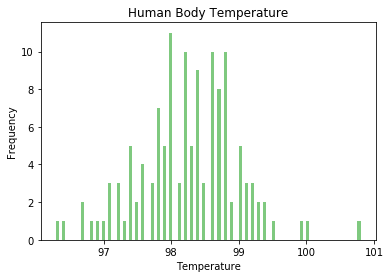

In [4]:
#Temperature stats
print(df['temperature'].describe())

#plot the sample
df['temperature'].plot(kind='hist',bins=100, color = COLOR1)
pyplot.xlabel('Temperature')
pyplot.title('Human Body Temperature')
None

In [5]:
#We can consider it to be normal distribution with following attributes

print('skew: ',scipy.stats.skew(df['temperature']))
print('kurtosis: ', scipy.stats.kurtosis(df['temperature']))
#Distribution is slightly skewed towards left, -0.004
#
#Kurtosis is 0.704
#A distribution with kurtosis <3 is called platykurtic. Compared to a normal distribution, 
#its tails are shorter and thinner, and often its central peak is lower and broader.

skew:  -0.004367976879081625
kurtosis:  0.7049597854114693


In [6]:
#Central Limit theorem states the mean of the population is equal to the mean of "sample distribution of sample means"
#and also normal 
#Assuming our sample represents the population.


class Resampler(object):
    """Represents a framework for computing sampling distributions."""
    
    def __init__(self, sample, xlim=None):
        """Stores the actual sample."""
        self.sample = sample
        self.n = len(sample)
        self.xlim = xlim
        
    def resample(self):
        """Generates a new sample by choosing from the original
        sample with replacement.
        """
        new_sample = numpy.random.choice(self.sample, self.n, replace=True)
        return new_sample
    
    def sample_stat(self, sample):
        """Computes a sample statistic using the original sample or a
        simulated sample.
        """
        return sample.mean()
    
    def compute_sampling_distribution(self, iters=1000):
        """Simulates many experiments and collects the resulting sample
        statistics.
        """
        stats = [self.sample_stat(self.resample()) for i in range(iters)]
        return numpy.array(stats)
    
    def plot_sampling_distribution(self):
        """Plots the sampling distribution."""
        sample_stats = self.compute_sampling_distribution()
    
        pyplot.hist(sample_stats, color=COLOR2)
        pyplot.xlabel('sample mean')
        pyplot.xlim(self.xlim)
        pyplot.show()
        
#Above class Reference: Allen Downey Random sampling

In [7]:
temperatures = scipy.stats.norm(df['temperature'].mean(), df['temperature'].std())

The following function instantiates a Resampler and runs it.

In [8]:
def interact_func(n, xlim):
    sample = temperatures.rvs(n)
    resampler = Resampler(sample, xlim=xlim)
    resampler.plot_sampling_distribution()

Here's a test run with n=100

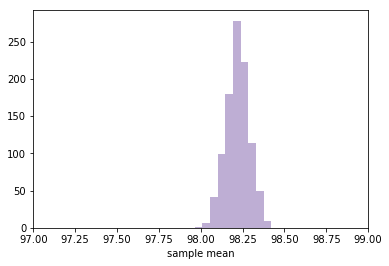

In [9]:
interact_func(n=100, xlim=[97, 99])

In [10]:
slider = widgets.IntSlider(min=10, max=1000, value=100)
interact(interact_func, n=slider, xlim=fixed([97, 100]))
None

<div class="span5 alert alert-info">
Is the sample size large? Are the observations independent?
</div>

The sample size > 30, which is considerable model to represent a population.<br>
Observations are independent as the occurrence of one observation provides no information about the occurrence of the other observation.

<div class="span5 alert alert-info">
Is the true population mean really 98.6 degrees F?
</div>

__One-sample z-test__<br>
Conditions to be satisfied:<br>
Experimental Design:  The sample forms a single treatment group.<br>
Population Distribution:  Arbitrary.<br>
Sample Size:  n > 30

H$_{0}$: Mean normal temperature is 98.6$^{\circ}$F<br>
H$_{1}$: Mean normal temperature is not 98.6$^{\circ}$F

In [11]:
stat, p = scipy.stats.ttest_1samp(df['temperature'], 98.6)
stat, p

(-5.4548232923645195, 2.4106320415561276e-07)

-5.45 $\not\in$ [-1.96, 1.96], which is 95% confidence interval for z.<br>
So, reject H$_{0}$<br>
For sample size > 30, both t-statistic and z-statistic provide the same result.

<div class="span5 alert alert-info">
At what temperature should we consider someone's temperature to be "abnormal"?
</div>

In [12]:
se = numpy.std(df['temperature'])
ci = numpy.percentile(df['temperature'], [5, 95])
print('Standard Error: ', se)
print('Confidence Interval: ', ci)

Standard Error:  0.7303577789050377
Confidence Interval:  [ 97.045  99.3  ]


Temperature $\not\in$ [97.045, 99.3] (3 standard deviations) can be considered abnormal

<div class="span5 alert alert-info">
Is there a significant difference between males and females in normal temperature?
</div>

In [13]:
male_temp = df[df['gender']=='M']['temperature']
female_temp = df[df['gender']=='F']['temperature']
mean_diff = male_temp.mean()-female_temp.mean()

__Paired-sample z-test __
 
Experimental Design:  There is no natural pairing between subjects in the two groups.<br>
Population Distribution:  Arbitrary.<br>
Sample Size:  n ≥ 30 for both groups.<br>

H$_{0}$:  The mean of the sample differences is not significantly different from 0.<br>
H$_{1}$:  The mean of the sample differences is significantly different from 0.

$z = \frac{\bar{x}-\mu}{SE_{mean}}$<br>
$\bar{x}$ is the sample mean difference<br>

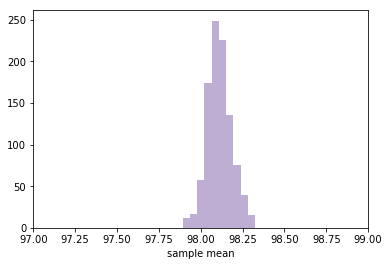

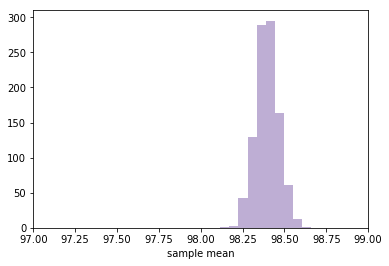

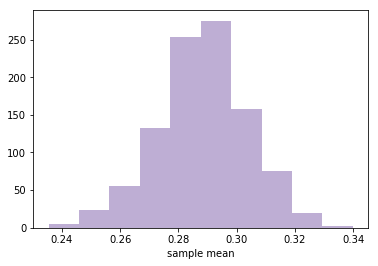

z stat:  -2.28543453817


In [14]:
#visualize male means, female means and difference between means of both
def interact_func_ar(ar, n, xlim=None):
    sample = ar.rvs(n)
    resampler = Resampler(sample, xlim=xlim)
    resampler.plot_sampling_distribution()

male_temperatures = scipy.stats.norm(male_temp.mean(), male_temp.std())
interact_func_ar(male_temperatures,n=100, xlim=[97, 99])

female_temperatures = scipy.stats.norm(female_temp.mean(), female_temp.std())
interact_func_ar(female_temperatures,n=100, xlim=[97, 99])

diff_std = numpy.sqrt(((male_temp.std()**2)/65)+((female_temp.std()**2)/65))
diff = scipy.stats.norm(abs(mean_diff), diff_std)
interact_func_ar(diff,n=65)

z_stat = (mean_diff-0)/diff_std    #'0' because null hypothesis states no significant difference between groups
print('z stat: ', z_stat)

From the z-statistic above, we can reject our null hypothesis<br>
Because z stat $\not\in$ [-1.96, 1.96], which is 95% confidence interval for z.<br>
The mean of the sample differences is significantly different from 0.

##### Conclusion
The mean normal temperature varies from men to women.<br>
Also it is not 98.6$^{\circ}$F, from the data we have.